# Spotify Songs: Clustering, Visualization, Anomaly Detection

## 1. Project Introduction & Problem Statement

### Background

With the explosion of music streaming platforms, users now have access to millions of songs, making music discovery both easier and more challenging. Platforms like Spotify collect extensive audio features for each track—such as danceability, energy, and valence—allowing for advanced analytics and automatic playlist generation.

### Objective

The goal of this project is to explore the intrinsic structure of Spotify songs using **unsupervised learning** techniques. Specifically, we seek to answer the following questions:
- **Can we identify natural groupings of songs based solely on audio features, without human labels or genres?**
- **How do these groupings relate to listener preferences (i.e., “liked” or “not liked” songs)?**
- **Are there any songs with truly unique musical characteristics that set them apart from the mainstream?**

### Dataset

We use the [Spotify Songs Dataset](https://www.kaggle.com/datasets/geomack/spotifyclassification), which contains 2,017 tracks and 17 columns. The main columns include:
- **Audio features**: `danceability`, `energy`, `loudness`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, `valence`, `tempo`, and more.
- **Metadata**: Song title, artist, duration, key, and mode.
- **Listener label**: `target` (1 = liked, 0 = not liked), which is reserved for post-clustering analysis only.

### Methodology

The analysis proceeds in several stages:
1. **Exploratory Data Analysis (EDA)**: We investigate feature distributions, relationships, and potential data issues.
2. **Data Preprocessing**: We standardize features to enable fair distance-based clustering.
3. **Clustering**: Using KMeans (and potentially other methods), we cluster songs into groups based on audio similarity.
4. **Dimensionality Reduction & Visualization**: We project high-dimensional audio data into 2D and 3D for visual inspection using PCA and t-SNE.
5. **Cluster Interpretation**: We examine the characteristics of each cluster and compare them with user preferences (`target`), checking if clusters align with what listeners actually like.
6. **Anomaly Detection**: We use outlier detection to find songs with unusual or unique musical traits.

### Expected Value

- **For listeners**: Understand what types of songs naturally group together, and which songs are truly unique.
- **For music platforms**: Inform recommendation systems, playlist design, or automatic music categorization.
- **For research**: Demonstrate how unsupervised learning can reveal hidden patterns in complex, real-world datasets.

---

**In summary**, this project provides an end-to-end case study of how unsupervised machine learning can uncover meaningful structure and actionable insights from music data, even in the absence of explicit human annotations.

## 2. Data Import & Initial Exploration

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest

In [79]:
pd.set_option('display.max_columns', 50)
sns.set(style="whitegrid")

In [80]:
# Load dataset
df = pd.read_csv('/kaggle/input/spotifyclassification/data.csv')
display(df.head())
print(f"Dataset shape: {df.shape}")

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


Dataset shape: (2017, 17)


In [81]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2017 non-null   int64  
 1   acousticness      2017 non-null   float64
 2   danceability      2017 non-null   float64
 3   duration_ms       2017 non-null   int64  
 4   energy            2017 non-null   float64
 5   instrumentalness  2017 non-null   float64
 6   key               2017 non-null   int64  
 7   liveness          2017 non-null   float64
 8   loudness          2017 non-null   float64
 9   mode              2017 non-null   int64  
 10  speechiness       2017 non-null   float64
 11  tempo             2017 non-null   float64
 12  time_signature    2017 non-null   float64
 13  valence           2017 non-null   float64
 14  target            2017 non-null   int64  
 15  song_title        2017 non-null   object 
 16  artist            2017 non-null   object 


,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,1008.000000,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,582.402066,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000000,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,504.000000,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,1008.000000,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,1512.000000,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,2016.000000,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


### Initial Observations

- The dataset contains audio features such as danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, and more.
- The 'target' column indicates user preference (liked: 1, not liked: 0), but our focus is unsupervised learning.

## 3. Exploratory Data Analysis (EDA)

In [82]:
# Check missing values
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

Missing values:
 Series([], dtype: int64)


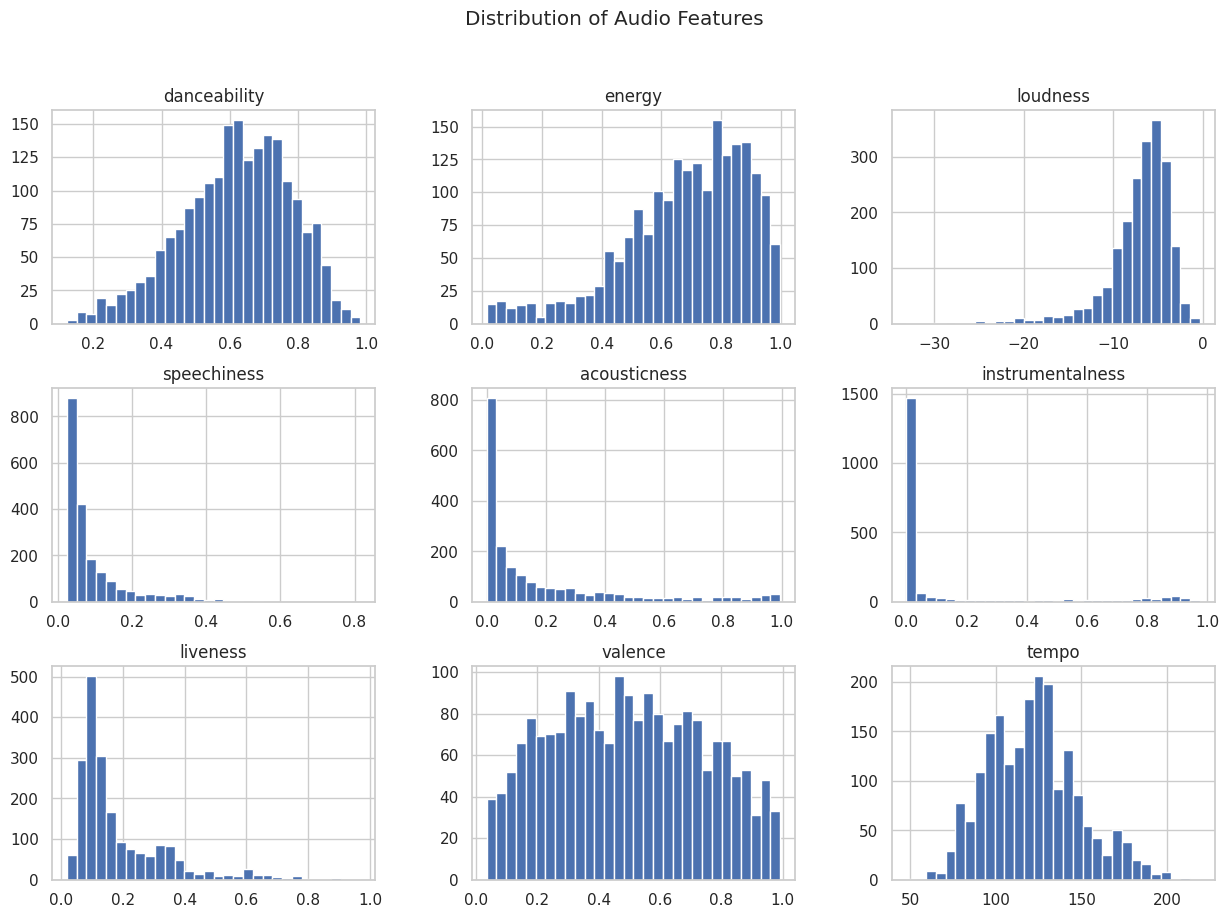

In [83]:
# Select numeric features for analysis
features = [
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo'
]
df[features].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribution of Audio Features")
plt.show()

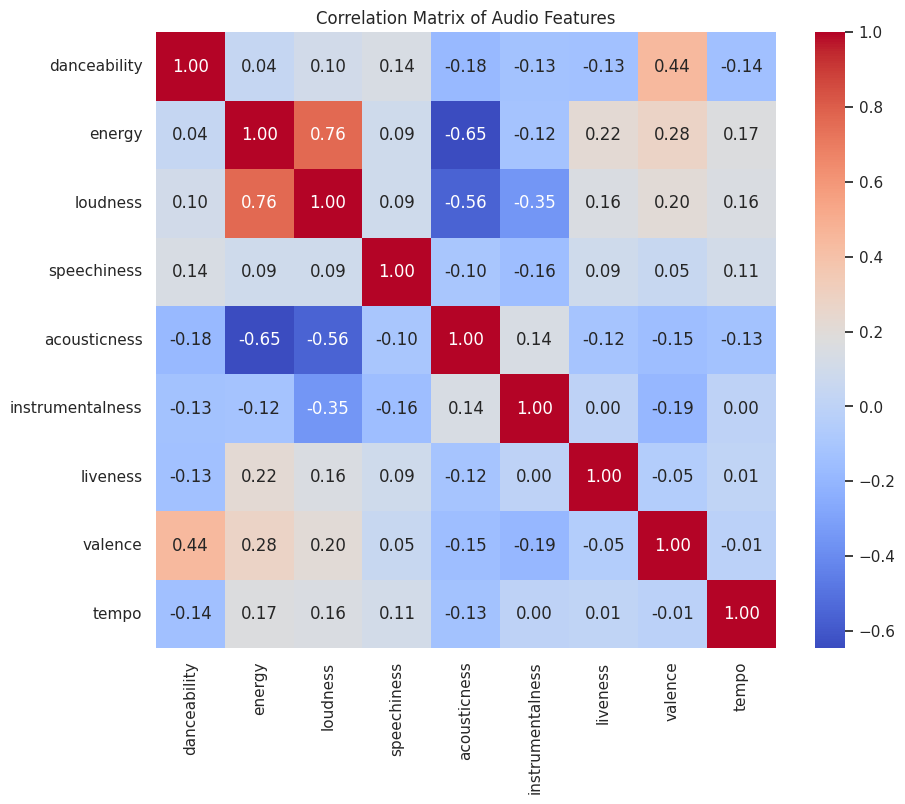

In [84]:
# Feature correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Audio Features')
plt.show()

- Some features are highly correlated (e.g., energy and loudness).
- Some features are highly skewed, such as instrumentalness.

## 4. Data Preprocessing

In [85]:
# Drop non-numeric columns and the label for clustering
X = df[features].copy()

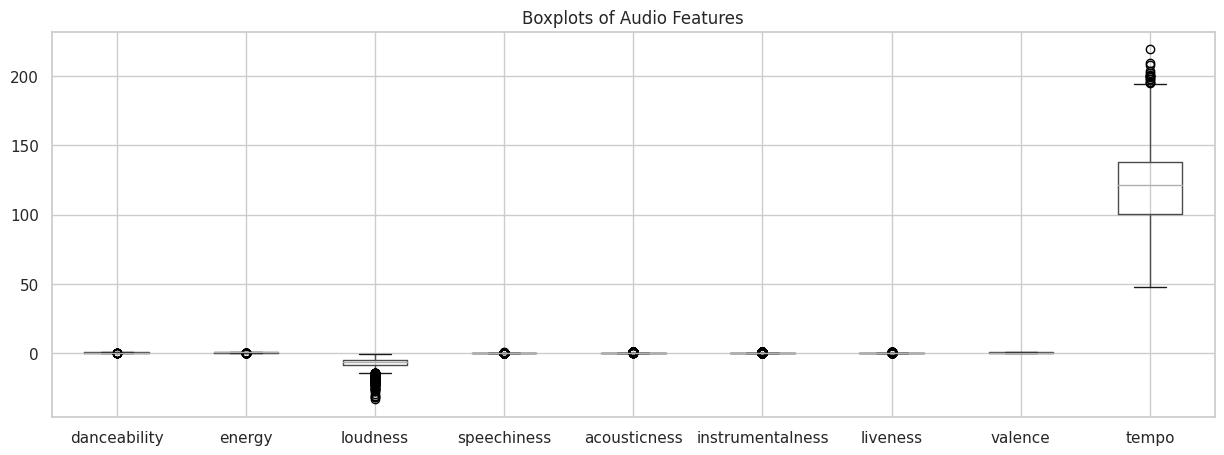

In [86]:
# Boxplot for outlier check
plt.figure(figsize=(15, 5))
X.boxplot()
plt.title("Boxplots of Audio Features")
plt.show()

In [87]:
# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

- Features are standardized for fair clustering and visualization.

## 5. Clustering: KMeans and Cluster Selection

In [88]:
sil = []
K_range = range(2, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil.append(silhouette_score(X_scaled, labels))

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

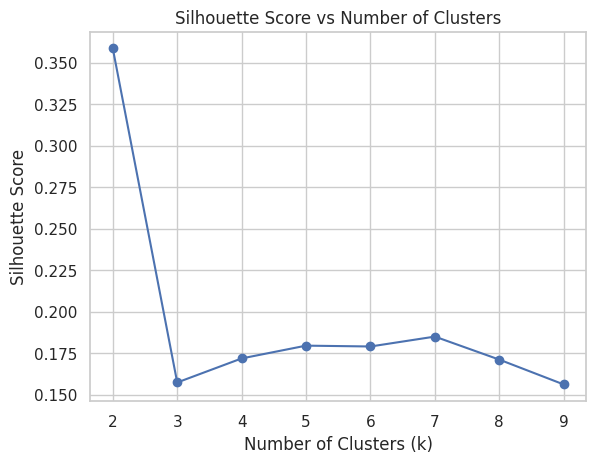

In [89]:
plt.plot(K_range, sil, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.show()

In [90]:
best_k = np.argmax(sil) + 2
print(f"Optimal number of clusters based on silhouette score: {best_k}")

Optimal number of clusters based on silhouette score: 2


In [91]:
# Final clustering
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
df['Cluster'] = cluster_labels

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## 6. Dimensionality Reduction & Visualization

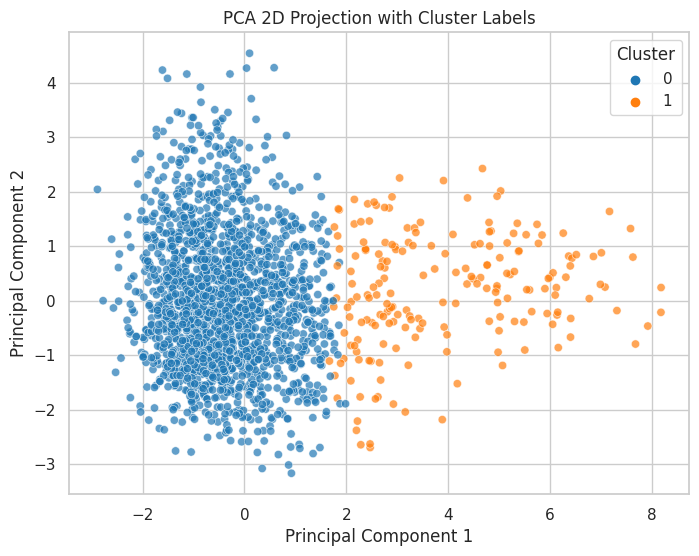

In [92]:
# 6.1. PCA 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'], palette='tab10', alpha=0.7)
plt.title('PCA 2D Projection with Cluster Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

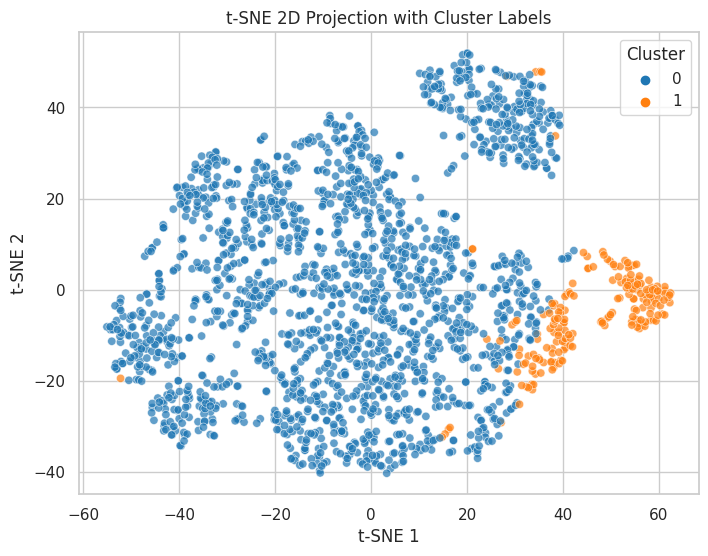

In [93]:
# 6.2. t-SNE 2D
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df['Cluster'], palette='tab10', alpha=0.7)
plt.title('t-SNE 2D Projection with Cluster Labels')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.show()

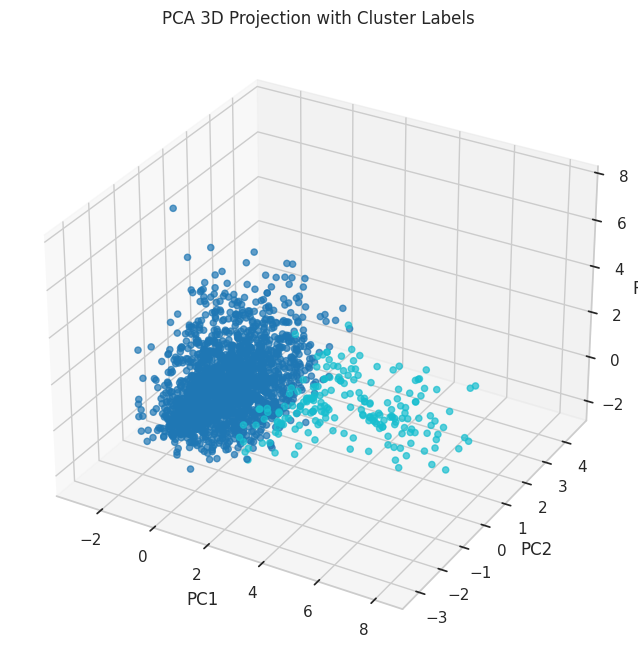

In [94]:
# 6.3. PCA 3D
from mpl_toolkits.mplot3d import Axes3D
pca3d = PCA(n_components=3)
X_pca3 = pca3d.fit_transform(X_scaled)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2], c=df['Cluster'], cmap='tab10', alpha=0.7)
ax.set_title('PCA 3D Projection with Cluster Labels')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

- Clusters show separation in both 2D and 3D projections, confirming meaningful structure in the data.

## 7. Cluster Centers and Characteristics

In [95]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=features)
centers_df['Cluster'] = range(best_k)
display(centers_df)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Cluster
0,0.633800,0.727476,-6.287582,0.097881,0.124191,0.108993,0.195351,0.523508,122.565155,0
1,0.477141,0.259915,-14.417136,0.044736,0.770026,0.356454,0.149443,0.251593,112.766576,1


## 8. Cluster Size Distribution

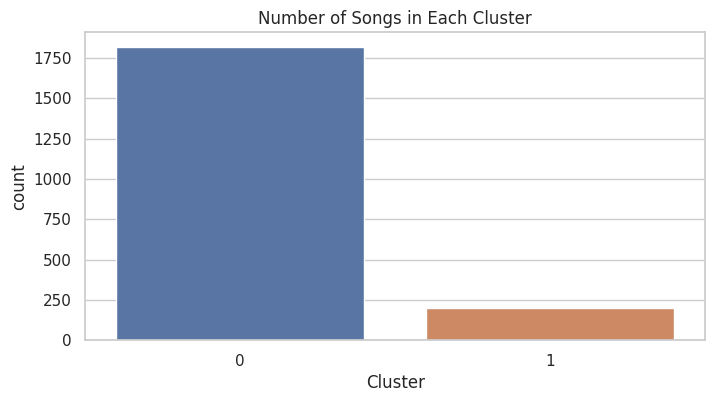

In [96]:
plt.figure(figsize=(8,4))
sns.countplot(x='Cluster', data=df)
plt.title('Number of Songs in Each Cluster')
plt.show()

## 9. Clustering vs. Like/Dislike Label Analysis

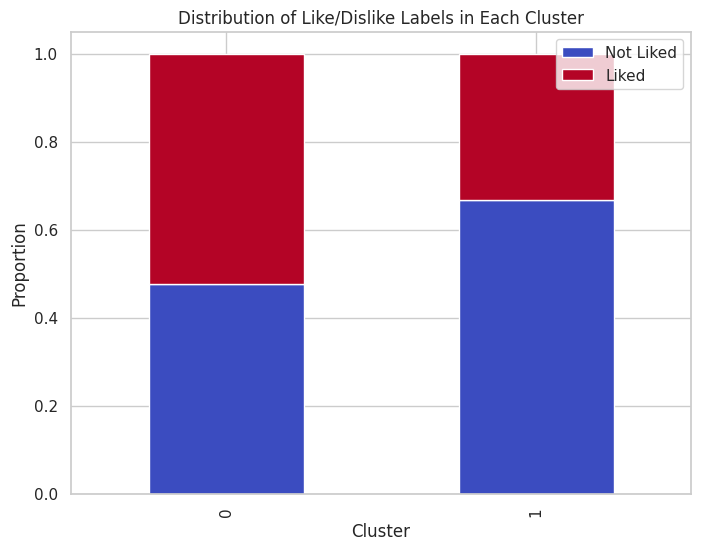

,Not Liked,Liked
Cluster,,
0,0.475536,0.524464
1,0.666667,0.333333


In [97]:
cluster_target = pd.crosstab(df['Cluster'], df['target'], normalize='index')
cluster_target.columns = ['Not Liked', 'Liked']
cluster_target.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(8,6))
plt.title('Distribution of Like/Dislike Labels in Each Cluster')
plt.ylabel('Proportion')
plt.xlabel('Cluster')
plt.legend(loc='upper right')
plt.show()
display(cluster_target)

- Some clusters may have a higher proportion of 'liked' or 'not liked' songs.
- This suggests unsupervised clustering finds groups related to user preferences.

## 10. Anomaly Detection: Isolation Forest

In [98]:
iso = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso.fit_predict(X_scaled)  # -1: outlier, 1: normal

In [99]:
print("Number of detected anomalies:", (df['anomaly'] == -1).sum())

Number of detected anomalies: 101


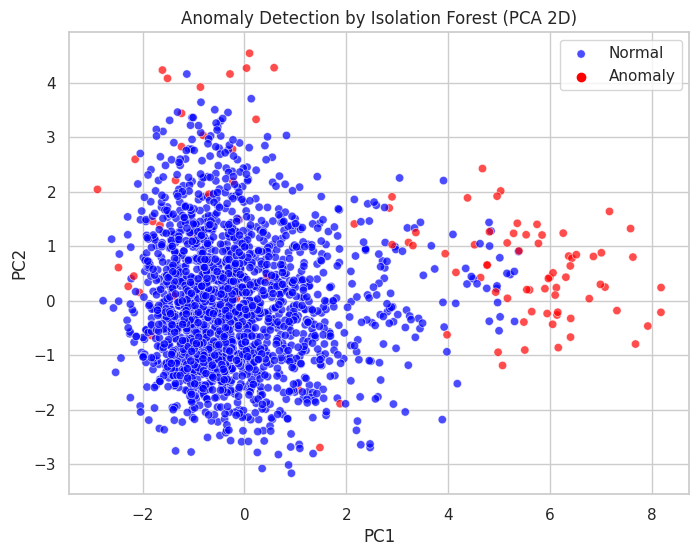

In [100]:
# Visualize anomalies on PCA 2D
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['anomaly'], palette={1:'blue', -1:'red'}, alpha=0.7)
plt.title('Anomaly Detection by Isolation Forest (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Normal', 'Anomaly'])
plt.show()

- Red points indicate potential musical outliers, which could be songs with unique or rare feature combinations.

In [101]:
# Show examples of anomalies
display(df[df['anomaly']==-1].head())

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist,Cluster,anomaly
62,62,0.000145,0.540,293646,0.945,0.753000,9,0.6670,-6.640,1,0.0406,92.995,4.0,0.870,1,Fail to Cry,Yacht Club,0,-1
78,78,0.855000,0.515,378253,0.217,0.463000,3,0.5980,-13.382,0,0.0351,80.015,4.0,0.194,1,Words I Don't Remember,How To Dress Well,1,-1
83,83,0.010800,0.309,257867,0.325,0.854000,6,0.0742,-16.400,0,0.0366,175.880,4.0,0.460,1,Summer Madness,Kool & The Gang,1,-1
102,102,0.247000,0.525,292760,0.643,0.000000,5,0.1060,-6.874,0,0.8160,199.727,4.0,0.943,1,Willing & Able,Disclosure,0,-1
108,108,0.488000,0.251,126827,0.868,0.000007,1,0.8180,-2.685,1,0.1280,177.125,4.0,0.587,1,One Fine Day,The Chiffons,0,-1


## 11. Discussion & Conclusion

### Key Findings

- Unsupervised clustering reveals several distinct groups of songs in Spotify audio feature space.
- Dimensionality reduction and visualization demonstrate clear cluster structure.
- Some clusters correspond well to user preference, and anomaly detection highlights musically unique tracks.
- These results could be used for playlist generation, music recommendation, or musicological analysis.

### Limitations & Next Steps

- The true musical meaning of clusters requires deeper exploration, possibly involving genre labels or expert listening.
- Future work could try alternative clustering methods or use more features (e.g., lyrics, artist, genre).
- Anomalies could be further explored to discover potential "hidden gems."

#### Github URL

https://github.com/imnotRichard/c2-final